# Text Classification on user complaints using W&B Tables and Artifacts

# Create a baseline model

We are going to build a baseline model, our first approach to the problema. Later we can compare more advanced model, trying to get a better performance.
This initial model is a Convolutional 1D model in keras applied to a text classificatio task. It is a simple and small model that we can easily use in a low performance compute instance.

### Importing the libraries

First, we need to download the wandb library

In [1]:
!pip install wandb -qqq
!pip install scikit-plot

In [5]:
!pip install keras tensorflow

     |████████████████████████████████| 524.1 MB 19 kB/s /s eta 0:00:01                   | 31.2 MB 3.5 MB/s eta 0:02:23 |█████                           | 82.2 MB 22.2 MB/s eta 0:00:20��███▍                        | 120.6 MB 22.2 MB/s eta 0:00:19MB 22.2 MB/s eta 0:00:18��███▍                      | 154.5 MB 22.2 MB/s eta 0:00:17��▋               | 271.7 MB 17.9 MB/s eta 0:00:15:00:04:00:04     |██████████████████████▌         | 368.2 MB 46.3 MB/s eta 0:00:04     |██████████████████████▊         | 371.3 MB 46.3 MB/s eta 0:00:04�██████████▌        | 385.1 MB 71.4 MB/s eta 0:00:02�██████████▊        | 387.7 MB 71.4 MB/s eta 0:00:02��████████████        | 392.7 MB 71.4 MB/s eta 0:00:02��██▋     | 436.1 MB 71.4 MB/s eta 0:00:02MB 125.4 MB/s eta 0:00:01████▊  | 487.0 MB 125.4 MB/s eta 0:00:01�████████████████████████▉ | 505.6 MB 125.4 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 6.9 MB/s  eta 0:00:01
     

In [6]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import seed

from pathlib import Path

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import set_random_seed

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense

from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

2023-08-27 17:05:37.380253: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 17:05:37.442295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 17:05:37.443291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 17:05:38.421535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


We are setting seed for reproducibility

In [7]:
# To reproduce the experiment
s=42
# Set the seed for reproducibility
set_random_seed(s)

## Download the data from W&B Artifacts

Download the data from the Artifact we save previously, we will use W&B Artifacts to track the lineage of our models.

In [15]:
WANDB_PROJECT = "consumer_complaints_classification"
ENTITY = None # set this to team name if working in a team
RAW_DATA_AT = 'consumer_complaints_eda'
PROCESSED_DATA_AT = 'consumer_complaints_split'
SPLIT_FILENAME = 'consumer_complaints_split.csv'
BASELINE_DATA_AT = 'consumer_complaints_baseline'

In [16]:
# Init the wandb session in our project
run = wandb.init(project=WANDB_PROJECT, entity=None, job_type="training")
# Define the artifact to use
processed_data_at = run.use_artifact(f'{PROCESSED_DATA_AT}:latest', type='split_data')
# Download the data in the artifact
processed_dataset_dir = Path(processed_data_at.download())


wandb: Downloading large artifact consumer_complaints_split:latest, 98.06MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:0.8


In [17]:
processed_dataset_dir

PosixPath('artifacts/consumer_complaints_split:v0')

In [18]:
# Read the data from the artifact as a csv file
df = pd.read_csv(processed_dataset_dir / SPLIT_FILENAME)
# Show some data
df.head(5)

,product,narrative,stage
0,credit_card,card hacked called able cancel card order repl...,train
1,debt_collection,received letter convergent outsourcing inc was...,train
2,credit_reporting,much time many error law broken funny year try...,train
3,credit_reporting,past two month trying get total hard inquiry r...,train
4,credit_reporting,reporting outrageous erroneous debt credit fil...,train


## Create the train, validation and test dataset for training

We need to convert the product column to numerical values

In [19]:
# Extract the unique category values
target_classes = df['product'].unique()
# Create a dictionary
target_values = dict(zip(target_classes, range(5)))
# Replace values in column product with integer values using the dict
df.replace({'product': target_values}, inplace=True)
# Show the conversion
df.head(5)

,product,narrative,stage
0,0,card hacked called able cancel card order repl...,train
1,1,received letter convergent outsourcing inc was...,train
2,2,much time many error law broken funny year try...,train
3,2,past two month trying get total hard inquiry r...,train
4,2,reporting outrageous erroneous debt credit fil...,train


In [20]:
df['product'].value_counts()

product
1    15000
4    15000
2    15000
0    14983
3    13469
Name: count, dtype: int64

We create our train and validation dataset, defining the array of features and the array of label for every dataset

In [21]:
# Create the train dataset
X_train= df[df['stage']=='train']['narrative'].values
Y_train= df[df['stage']=='train']['product'].values
# Create the validation dataset
X_val= df[df['stage']=='validation']['narrative'].values
Y_val= df[df['stage']=='validation']['product'].values

# Create the validation dataset
X_test= df[df['stage']=='test']['narrative'].values
Y_test= df[df['stage']=='test']['product'].values

In [22]:
print('Train dataset size: ',X_train.shape, ' Validation dataset size: ',X_val.shape)
print('Target classes: ', target_classes)

Train dataset size:  (51416,)  Validation dataset size:  (11018,)
Target classes:  ['credit_card' 'debt_collection' 'credit_reporting' 'retail_banking'
 'mortgages_and_loans']


## Tokenize and create the vocabulary

In this, we have implemented the first two steps we mentioned earlier to prepare data for the neural network.

We have first created an instance of Tokenizer class available from 'keras.preprocessing.text' module. This tokenizer instance will be used for populating vocabulary and generating indexes of tokens. After creating an instance, we have called fit_on_texts() method on it with train and test text examples. This step will internally loop through all text examples, tokenize them and populate vocabulary.

Next, we have called texts_to_sequences() method on Tokenizer object. We have provided a list of train and text examples for this method. This method tokenizes text examples and retrieves their token indexes from the vocabulary. We know that each text example has a different size text and we want input to a neural network with the same size. For this, we have wrapped call to texts_to_sequences() inside of call to function pad_sequences() function. We have decided to keep maximum of 128 tokens per text example. The pad_sequences() function ensures this. It truncates all text examples that have more than 128 tokens to 128 tokens and pads all text examples that have less than 128 tokens with 0s to bring them to the length of 128.

In [23]:
max_tokens = 128 ## Hyperparameter

tokenizer = Tokenizer()
tokenizer.fit_on_texts(np.concatenate([X_train,X_val]))

## Vectorizing data to keep max_tokens words per sample.
X_train_vect = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_tokens, padding="post", truncating="post", value=0.)
X_val_vect  = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_tokens, padding="post", truncating="post", value=0.)
X_test_vect  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_tokens, padding="post", truncating="post", value=0.)
# Show an example
print(X_train_vect[:3])

print(' Train size: ',X_train_vect.shape, ' Validation: ',X_val_vect.shape, ' Test: ',X_test_vect.shape)

[[    5  1422    17   103   472     5   179  1401   118   103   282   391
    332    15  3392   470   447    22   321  1688    33  2445   261   704
      1     1   888   421  2950  6687     5  5755    61   282   138    24
     23   559     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [   11    18  1912  2224   947  2489   617   315    16   630    18   547
    274    18    16   153   234    65   152    39  1488   321     1    17
    114   404   259   646     1    22     7   536    79   531

## Create our baseline model: CNN with Single Conv1D Layer

Our first approach creates a Convolutional neural network with a single 1D convolution layer for the text classification task. The network has 3 layers namely the embedding layer, convolution layer, and dense layer. The embedding layer maps token index to embeddings which are given to Conv1D for performing convolution operation. The output of the convolution layer is given to the dense layer to generate probabilities for target classes. After training the network, we have also evaluated the performance by calculating various ML metrics.

**Our goal is to show you how to integrate this training job with W&B Artifacts to store the artifacts and register the baseline model metrics. That's why we use such a simple model, we are not into getting the best model.**

After defining the network, we initialized it and printed a summary of the network parameters count.

In [24]:
embed_len = 128

inputs = Input(shape=(max_tokens, ))
embeddings_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embed_len,  input_length=max_tokens)
conv = Conv1D(32, 7, padding="same") ## Channels last
dense = Dense(len(target_classes), activation="softmax")

x = embeddings_layer(inputs)
x = conv(x)
x = tf.reduce_max(x, axis=1)
output = dense(x)

model = Model(inputs=inputs, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 128)          4689664   
                                                                 
 conv1d (Conv1D)             (None, 128, 32)           28704     
                                                                 
 tf.math.reduce_max (TFOpLa  (None, 32)                0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 4718533 (18.00 MB)
Trainable params: 4718533 (18.00 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

## Train the model 

In order to keep track of our experiment hyperparameters, we registry these values in W&B, in the config section of our experiment

In [25]:
# Define a config dictionary object
train_config = {
  "embedding_size": embed_len,
  "max_tokens": max_tokens,
  "batch_size": 256,
  "cnn_layers": 1,
  "epochs": 5,
  "dropout": 0,
  "num_classes": 5,
  "pretrained": False,
  "seed": 42
}

wandb.config=  train_config

Next, we compile our network to use Adam optimizer, cross entropy loss, and accuracy metric.

In [26]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

**REESCRIBIR**
In this section, we have trained our network by calling fit() method. We have provided the method with train and validation data. We have set batch size at 1024 and trained the network for 8 epochs. We can notice from the loss and accuracy values getting printed after each epoch that our network is doing a good job at the text classification task.

After training the network, we have also plotted loss and accuracy values from history object.

In [27]:
history = model.fit(X_train_vect, Y_train, batch_size=512, epochs=5, validation_data=(X_val_vect, Y_val),
                    callbacks=[WandbMetricsLogger(),
                               WandbModelCheckpoint(filepath="model", monitor="val_accuracy", save_best_only=True, mode="max"),                               
                              ])

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/5
101/101 [==============================] - ETA: 0s - loss: 1.0573 - accuracy: 0.6790INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
wandb: Adding directory to artifact (./model)... Done. 0.2s


101/101 [==============================] - 29s 280ms/step - loss: 1.0573 - accuracy: 0.6790 - val_loss: 0.5838 - val_accuracy: 0.7957
Epoch 2/5
101/101 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.8342INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
wandb: Adding directory to artifact (./model)... Done. 0.2s


101/101 [==============================] - 28s 278ms/step - loss: 0.4896 - accuracy: 0.8342 - val_loss: 0.4757 - val_accuracy: 0.8394
Epoch 3/5
101/101 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8673INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
wandb: Adding directory to artifact (./model)... Done. 0.1s


101/101 [==============================] - 29s 292ms/step - loss: 0.3953 - accuracy: 0.8673 - val_loss: 0.4531 - val_accuracy: 0.8457
Epoch 4/5
101/101 [==============================] - ETA: 0s - loss: 0.3331 - accuracy: 0.8897INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
wandb: Adding directory to artifact (./model)... Done. 0.1s


101/101 [==============================] - 28s 279ms/step - loss: 0.3331 - accuracy: 0.8897 - val_loss: 0.4454 - val_accuracy: 0.8488
Epoch 5/5
101/101 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.9103INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
wandb: Adding directory to artifact (./model)... Done. 0.2s


101/101 [==============================] - 28s 279ms/step - loss: 0.2781 - accuracy: 0.9103 - val_loss: 0.4462 - val_accuracy: 0.8516


We plot the loss and accuracy during training in both train and validation datasets. Loss and accuracy in the training dataset are much better than in validation dataset, maybe some overfitting is observed. But this is just an initial baseline model we can compare to later.

In [28]:
# CReate a function to print
def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss")
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.title("Train Loss vs Validation Loss")
    plt.legend(loc="best")
    plt.savefig('loss.png')

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy")
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy")
    plt.title("Train Accuracy vs Validation Accuracy")
    plt.legend(loc="best");
    plt.savefig('accuracy.png')


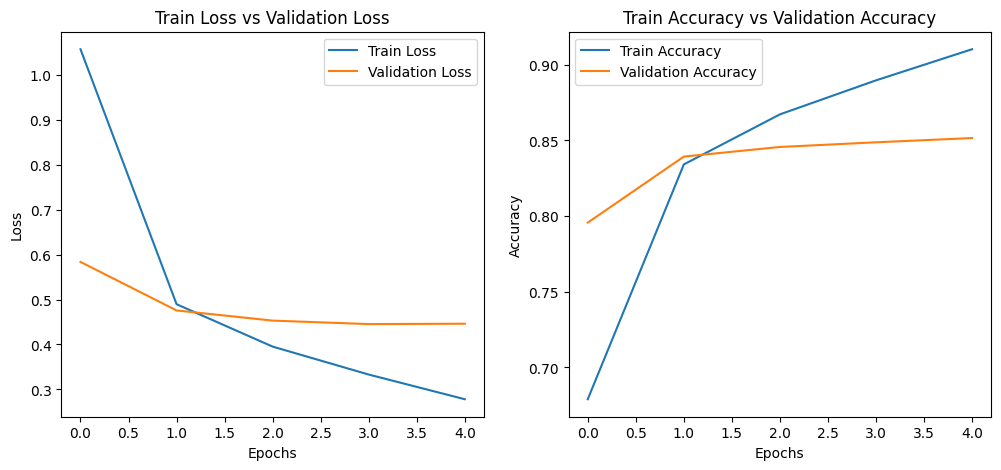

In [29]:
plot_loss_and_acc(history)

## Evaluate the model

In this section, we evaluate the performance of our trained network on the test dataset. We calculate the classification report (precision, recall, and f1-score per target class) and confusion matrix metrics on test predictions. We can notice from the accuracy score that our network is doing a good job at the given classification task. Using scikit-learn we can calculate these metrics very easy.

In [30]:
train_preds = model.predict(X_train_vect)
# Later we use test values
#test_preds = model.predict(X_test_vect)
val_preds = model.predict(X_val_vect)

345/345 [==============================] - 2s 6ms/step


Calculate the classification report

In [31]:
print("\nClassification Report : ")
report = classification_report(Y_val, np.argmax(val_preds, axis=1), target_names=target_classes, output_dict=True)
print(report)


Classification Report : 
{'credit_card': {'precision': 0.8260303687635575, 'recall': 0.8473520249221184, 'f1-score': 0.8365553602811951, 'support': 2247.0}, 'debt_collection': {'precision': 0.8480613165013525, 'recall': 0.836, 'f1-score': 0.841987466427932, 'support': 2250.0}, 'credit_reporting': {'precision': 0.8287920072661217, 'recall': 0.8111111111111111, 'f1-score': 0.8198562443845463, 'support': 2250.0}, 'retail_banking': {'precision': 0.8748773307163886, 'recall': 0.8822365165759525, 'f1-score': 0.8785415126878541, 'support': 2021.0}, 'mortgages_and_loans': {'precision': 0.8824833702882483, 'recall': 0.8844444444444445, 'f1-score': 0.8834628190899002, 'support': 2250.0}, 'accuracy': 0.8516064621528409, 'macro avg': {'precision': 0.8520488787071336, 'recall': 0.8522288194107253, 'f1-score': 0.8520806805742855, 'support': 11018.0}, 'weighted avg': {'precision': 0.8515814926134426, 'recall': 0.8516064621528409, 'f1-score': 0.8515349413663414, 'support': 11018.0}}


to save this report we can convert it into a pandas Dataframe to save it in a W&b Artifact

In [32]:
df_report = pd.DataFrame(report).transpose()
df_report.reset_index(inplace=True)
df_report = df_report.rename(columns = {'index':'category'})
df_report.head(5)

,category,precision,recall,f1-score,support
0,credit_card,0.826030,0.847352,0.836555,2247.0
1,debt_collection,0.848061,0.836000,0.841987,2250.0
2,credit_reporting,0.828792,0.811111,0.819856,2250.0
3,retail_banking,0.874877,0.882237,0.878542,2021.0
4,mortgages_and_loans,0.882483,0.884444,0.883463,2250.0


Finally, we plot the confussion matrix and save it as image.

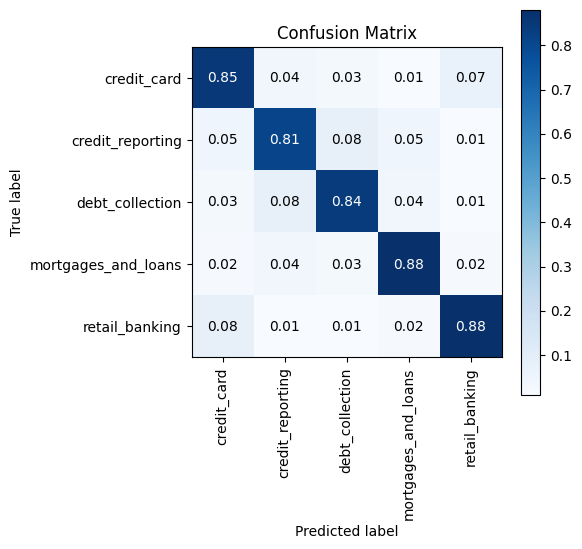

In [33]:
# Draw the confussion matrix for the test dataset
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_val], [target_classes[i] for i in np.argmax(val_preds, axis=1)],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);
plt.savefig('confussion_matrix.png')

In [36]:
X_test_vect  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_tokens, padding="post", truncating="post", value=0.)


In [42]:
val_preds

array([[1.21511956e-04, 3.88987273e-01, 6.10497892e-01, 1.36621065e-05,
        3.79741716e-04],
       [8.99548709e-01, 1.36654079e-02, 3.78717622e-03, 8.24173763e-02,
        5.81338361e-04],
       [9.95614529e-01, 2.57753837e-03, 5.64767746e-04, 4.67083213e-04,
        7.76138855e-04],
       ...,
       [3.48492056e-01, 9.33064446e-02, 4.99031335e-01, 3.52002028e-03,
        5.56501970e-02],
       [9.97119665e-01, 9.80884419e-04, 1.83944602e-03, 3.89707529e-05,
        2.10671387e-05],
       [6.88821316e-01, 1.69828255e-03, 7.66389712e-04, 3.08030844e-01,
        6.83169870e-04]], dtype=float32)

Make predictions for test set

In [54]:
df_val= pd.concat([pd.Series(X_val), pd.Series(Y_val), pd.DataFrame(val_preds)], axis=1)
df_val.columns = ['complaint','product','prob0','prob1','prob2','prob3','prob4']
df_val.head(5)

,complaint,product,prob0,prob1,prob2,prob3,prob4
0,already notified university improperly collect...,2,0.000122,0.388987,0.610498,0.000014,0.000380
1,first progress card give provisional credit di...,0,0.899549,0.013665,0.003787,0.082417,0.000581
2,opened credit card account capital one capital...,0,0.995615,0.002578,0.000565,0.000467,0.000776
3,writing today regard account kia motor finance...,4,0.015114,0.003105,0.030341,0.000722,0.950718
4,duplicate complaint synchrony need step forwar...,0,0.997044,0.000756,0.001113,0.000256,0.000831


In [39]:
df_val= pd.DataFrame([X_val, Y_val, val_preds], columns=['complaint','product','predicted_product'])
df_val.head(5)

ValueError: 3 columns passed, passed data had 11018 columns

## Save the W&B Artifacts

As we did in the EDA notebook, we store our baseline model, the evluation and the predictions on the test dataset. If we want to dive deeper in this results or if we want to compare them to some other model's results we can retrive this information.

In [34]:
#Create the artifact
baseline_data_at = wandb.Artifact(BASELINE_DATA_AT, type="baseline")
# Add the classifation report
baseline_data_at.add_file('accuracy.png')
baseline_data_at.add_file('loss.png')
baseline_data_at.add_file('confussion_matrix.png')
# Save the classification report
report_table = wandb.Table(dataframe=df_report)
baseline_data_at.add(report_table, "evaluation_table")


In [55]:
prediction_table = wandb.Table(dataframe=df_val)
baseline_data_at.add(prediction_table, "prediction_table")

In [56]:
run.log_artifact(baseline_data_at)
run.finish()

epoch/accuracy,▁▆▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/val_accuracy,▁▆▇██
epoch/val_loss,█▃▁▁▁
epoch/accuracy,0.91032
epoch/epoch,4
epoch/learning_rate,0.001
epoch/loss,0.27813
epoch/val_accuracy,0.85161


In [14]:
run.finish()